In [4]:
# Money Heist – Retrieval & Reranker Metrics Dashboard

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# So plots show inline
%matplotlib inline

# ---- Project config ----
PROJECT_ROOT = Path("/data/sundeep/Fandom_SI")
DOMAIN = "money-heist"

PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
LOGS_DIR      = PROJECT_ROOT / "data" / "logs"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DOMAIN:", DOMAIN)

PROJECT_ROOT: /data/sundeep/Fandom_SI
DOMAIN: money-heist


In [5]:
# ---- Load spans & queries ----

spans_csv = PROCESSED_DIR / f"spans_{DOMAIN}.csv"
anchor_queries_csv = PROCESSED_DIR / f"anchor_queries_{DOMAIN}.csv"  # update if different

spans_df = pd.read_csv(spans_csv)
print("Spans shape:", spans_df.shape)
display(spans_df.head())

try:
    anchor_df = pd.read_csv(anchor_queries_csv)
    print("\nAnchor queries shape:", anchor_df.shape)
    display(anchor_df.head())
except FileNotFoundError:
    anchor_df = None
    print("\n[WARN] anchor_queries CSV not found at:", anchor_queries_csv)

Spans shape: (3189, 13)


,span_id,article_id,page_name,title,section,span_index,start_char,end_char,len_chars,num_sents,text,url,source_path
0,money-heist_span_0000001,419,48_Meters_Underground,48 Meters Underground,Introduction,0,0,362,362,2.0,48 Meters Underground Part Number 3 03 Air dat...,https://money-heist.fandom.com/wiki/48_Meters_...,data/raw/fandom_html/money-heist/money-heist_f...
1,money-heist_span_0000002,419,48_Meters_Underground,48 Meters Underground,Synopsis [ ],0,0,142,142,2.0,Tokyo and Nairobi's efforts go drastically awr...,https://money-heist.fandom.com/wiki/48_Meters_...,data/raw/fandom_html/money-heist/money-heist_f...
2,money-heist_span_0000003,419,48_Meters_Underground,48 Meters Underground,Plot [ ],0,0,345,345,4.0,"After the Bank of Spain is attacked, the guard...",https://money-heist.fandom.com/wiki/48_Meters_...,data/raw/fandom_html/money-heist/money-heist_f...
3,money-heist_span_0000004,419,48_Meters_Underground,48 Meters Underground,Plot [ ],1,346,729,383,4.0,Then she storms in and tries to lead the Gover...,https://money-heist.fandom.com/wiki/48_Meters_...,data/raw/fandom_html/money-heist/money-heist_f...
4,money-heist_span_0000005,419,48_Meters_Underground,48 Meters Underground,Plot [ ],2,730,1038,308,4.0,Palermo introduces himself to the hostages. He...,https://money-heist.fandom.com/wiki/48_Meters_...,data/raw/fandom_html/money-heist/money-heist_f...



Anchor queries shape: (9018, 6)


,q_id,query,linked_word,paragraph_text,correct_article_id,source_article_id
0,1,Retrieve the correct article for the term '3' ...,3,48 Meters Underground Part Number 3 03 Air dat...,433,419
1,2,Retrieve the correct article for the term 'Jes...,Jesús Colmenar,48 Meters Underground Part Number 3 03 Air dat...,1440,419
2,3,Retrieve the correct article for the term 'Ále...,Álex Pina,48 Meters Underground Part Number 3 03 Air dat...,1435,419
3,4,Retrieve the correct article for the term 'Jav...,Javier Gómez Santander,48 Meters Underground Part Number 3 03 Air dat...,1443,419
4,5,Retrieve the correct article for the term 'Jua...,Juan Salvador López,48 Meters Underground Part Number 3 03 Air dat...,1454,419


Number of spans: 3189
Number of articles: 267
Average spans/article: 11.94
Median spans/article: 6.00


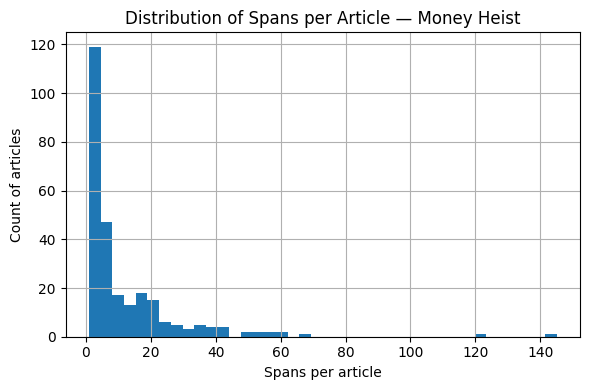

section
Plot [ ]                   484
Introduction               467
Main Cast [ ]              334
Biography [ ]              237
Supporting Cast [ ]        160
Trivia [ ]                 143
Personality [ ]            138
References [ ]             136
Part 1 [ ]                 113
Synopsis [ ]               112
Physical Appearance [ ]     83
Part 2 [ ]                  52
Part 5 [ ]                  47
Part 3 [ ]                  41
Part 4 [ ]                  35
Name: count, dtype: int64

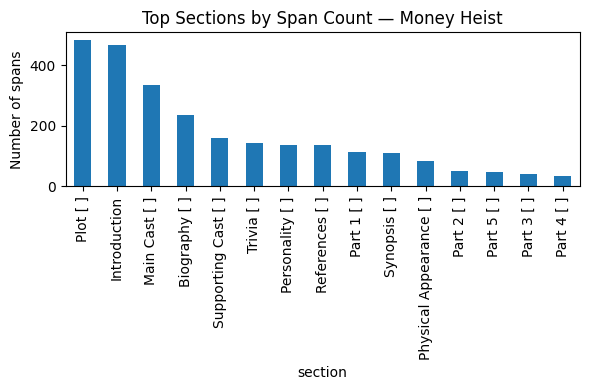

In [6]:
# ---- Basic dataset statistics ----

domain_title = DOMAIN.replace("-", " ").title()   # "money-heist" -> "Money Heist"

n_spans = len(spans_df)
n_articles = spans_df["article_id"].nunique()
spans_per_article = spans_df.groupby("article_id")["span_id"].count()

print(f"Number of spans: {n_spans}")
print(f"Number of articles: {n_articles}")
print(f"Average spans/article: {spans_per_article.mean():.2f}")
print(f"Median spans/article: {spans_per_article.median():.2f}")

# ---------- Histogram: Spans per article ----------
plt.figure(figsize=(6,4))
spans_per_article.hist(bins=40)
plt.xlabel("Spans per article")
plt.ylabel("Count of articles")
plt.title(f"Distribution of Spans per Article — {domain_title}")
plt.tight_layout()
plt.show()

# ---------- Top sections by count ----------
section_counts = spans_df["section"].value_counts().head(15)
display(section_counts)

plt.figure(figsize=(6,4))
section_counts.plot(kind="bar")
plt.ylabel("Number of spans")
plt.title(f"Top Sections by Span Count — {domain_title}")
plt.tight_layout()
plt.show()

Number of anchor queries: 9018
Unique target articles (in queries): 251
Average queries per article: 35.93
Median queries per article: 16.00


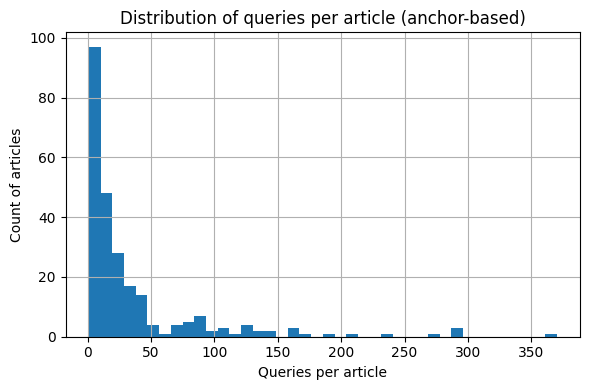

In [7]:
# ---- Anchor query statistics ----

if anchor_df is not None:
    n_queries = len(anchor_df)
    n_unique_articles_q = anchor_df["correct_article_id"].nunique()
    queries_per_article = anchor_df.groupby("correct_article_id")["q_id"].count()

    print(f"Number of anchor queries: {n_queries}")
    print(f"Unique target articles (in queries): {n_unique_articles_q}")
    print(f"Average queries per article: {queries_per_article.mean():.2f}")
    print(f"Median queries per article: {queries_per_article.median():.2f}")

    plt.figure(figsize=(6,4))
    queries_per_article.hist(bins=40)
    plt.xlabel("Queries per article")
    plt.ylabel("Count of articles")
    plt.title("Distribution of queries per article (anchor-based)")
    plt.tight_layout()
    plt.show()
else:
    print("No anchor query CSV loaded; skipping this section.")

Article-level FAISS metrics dataframe:


,metric,faiss
0,Recall@1,0.420603
1,Recall@3,0.581393
2,Recall@5,0.641717
3,Recall@10,0.745509
4,Recall@50,0.949324
5,Recall@100,0.949324
6,Recall@1000,0.949324
7,MRR@TOP_K,0.532198



Dtypes:
metric     object
faiss     float64
dtype: object


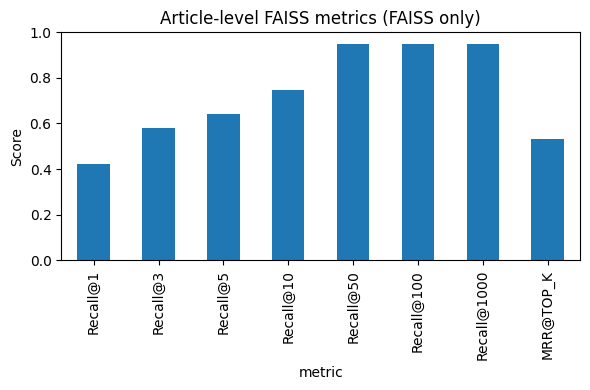

In [8]:
# ---- Article-level FAISS metrics ----

article_retrieval_metrics_csv = LOGS_DIR / "article_retrieval" / f"article_retrieval_metrics_{DOMAIN}.csv"

try:
    art_base_metrics = pd.read_csv(article_retrieval_metrics_csv)
    print("Article-level FAISS metrics dataframe:")
    display(art_base_metrics)
    print("\nDtypes:")
    print(art_base_metrics.dtypes)

    # metric = index, faiss = values
    plt.figure(figsize=(6, 4))
    (
        art_base_metrics
        .set_index("metric")["faiss"]
        .plot(kind="bar")
    )
    plt.ylabel("Score")
    plt.title("Article-level FAISS metrics (FAISS only)")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("[WARN] Article retrieval metrics CSV not found at:", article_retrieval_metrics_csv)
    art_base_metrics = None

Original metrics:


,metric,faiss,rerank
0,Recall@1,0.420603,0.916057
1,Recall@3,0.581393,0.947993
2,Recall@5,0.641717,0.948991
3,Recall@10,0.745509,0.949102
4,Recall@50,0.949324,0.949324
5,MRR@TOP_K,0.532198,0.932168



Metrics converted to percentages:


,metric,faiss,rerank
0,Recall@1,42.06%,91.61%
1,Recall@3,58.14%,94.8%
2,Recall@5,64.17%,94.9%
3,Recall@10,74.55%,94.91%
4,Recall@50,94.93%,94.93%
5,MRR@TOP_K,53.22%,93.22%


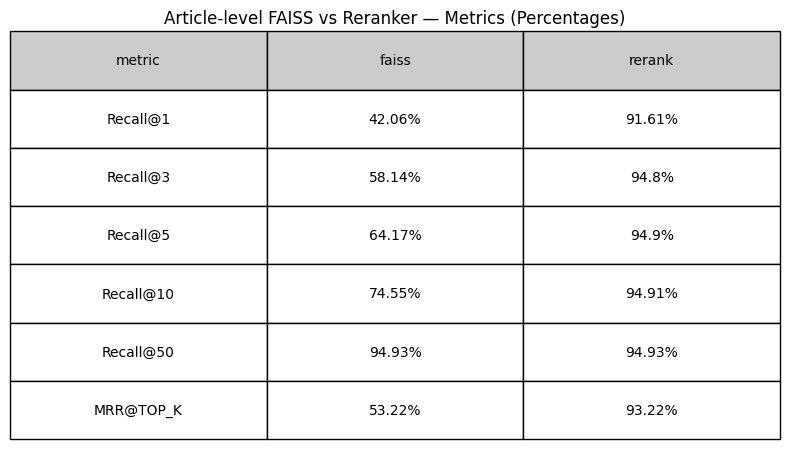

In [9]:
# ---- Article-level FAISS vs Reranker (TABLE AS PERCENTAGES) ----

import matplotlib.pyplot as plt
from matplotlib.table import Table

art_rerank_metrics_csv = LOGS_DIR / "article_reranker" / DOMAIN / f"article_reranker_vs_faiss_metrics_{DOMAIN}.csv"

try:
    art_rr = pd.read_csv(art_rerank_metrics_csv)
    print("Original metrics:")
    display(art_rr)

    # Convert numeric columns to percentages
    numeric_cols = ["faiss", "rerank"]
    for col in numeric_cols:
        art_rr[col] = (art_rr[col] * 100).round(2).astype(str) + "%"

    print("\nMetrics converted to percentages:")
    display(art_rr)

    # --- Create table image ---
    fig, ax = plt.subplots(figsize=(8, len(art_rr) * 0.6 + 1))
    ax.axis('off')

    tbl = Table(ax, bbox=[0, 0, 1, 1])

    cols = art_rr.columns.tolist()
    width = 1 / len(cols)
    height = 1 / (len(art_rr) + 1)

    # Header row
    for j, col in enumerate(cols):
        tbl.add_cell(0, j, width, height, text=col, loc='center', facecolor='#cccccc')

    # Data rows
    for i in range(len(art_rr)):
        for j, col in enumerate(cols):
            val = art_rr.iloc[i][col]
            tbl.add_cell(i + 1, j, width, height, text=str(val), loc='center')

    ax.add_table(tbl)

    plt.title("Article-level FAISS vs Reranker — Metrics (Percentages)")
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("[WARN] Article reranker metrics CSV not found at:", art_rerank_metrics_csv)

Sample of per-query ranks:


,q_id,query,linked_word,paragraph_text,gold_article_id,faiss_rank,rerank_rank,faiss_article_ids,rerank_article_ids
0,1,Retrieve the correct article for the term '3' ...,3,48 Meters Underground Part Number 3 03 Air dat...,433,2,1,436|433|1530|2211|471|420|417|419|418|434|2105...,433|419|436|417|322|418|424|423|420|434|422|21...
1,2,Retrieve the correct article for the term 'Jes...,Jesús Colmenar,48 Meters Underground Part Number 3 03 Air dat...,1440,1,1,1440|436|1530|2211|433|420|1699|419|417|434|41...,1440|419|494|418|424|2216|417|508|2448|1454|10...
2,3,Retrieve the correct article for the term 'Ále...,Álex Pina,48 Meters Underground Part Number 3 03 Air dat...,1435,1,1,1435|436|433|1458|419|2448|420|114|418|417|434...,1435|436|419|417|424|423|1457|2104|418|420|210...
3,4,Retrieve the correct article for the term 'Jav...,Javier Gómez Santander,48 Meters Underground Part Number 3 03 Air dat...,1443,1,1,1443|436|420|1454|433|2448|1737|419|1530|2132|...,1443|419|2104|2101|424|1460|2105|418|1922|417|...
4,5,Retrieve the correct article for the term 'Jua...,Juan Salvador López,48 Meters Underground Part Number 3 03 Air dat...,1454,1,1,1454|436|2132|420|419|433|418|417|1737|2448|42...,1454|419|423|418|2132|557|420|2448|422|2104|21...


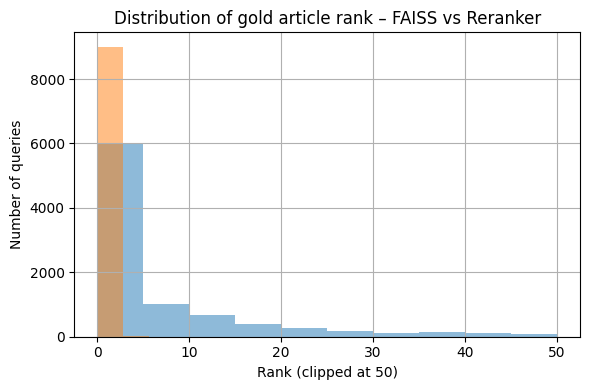

In [10]:
# ---- Article reranker per-query ranks ----

art_topk_csv = LOGS_DIR / "article_reranker" / DOMAIN / f"article_reranker_topk_{DOMAIN}.csv"

try:
    art_topk = pd.read_csv(art_topk_csv)
    print("Sample of per-query ranks:")
    display(art_topk.head())

    # Expect columns like: q_id, faiss_rank, rerank_rank, ...
    if {"faiss_rank", "rerank_rank"}.issubset(art_topk.columns):
        plt.figure(figsize=(6,4))
        art_topk["faiss_rank"].clip(upper=50).hist(alpha=0.5)
        art_topk["rerank_rank"].clip(upper=50).hist(alpha=0.5)
        plt.xlabel("Rank (clipped at 50)")
        plt.ylabel("Number of queries")
        plt.title("Distribution of gold article rank – FAISS vs Reranker")
        plt.tight_layout()
        plt.show()
    else:
        print("faiss_rank / rerank_rank columns not found; adjust this cell based on actual CSV schema.")

except FileNotFoundError:
    print("[WARN] Article reranker top-k CSV not found at:", art_topk_csv)

In [11]:
# ---- Span-level reranker metrics (adjust path if needed) ----

# Example guess; update to match your actual file
span_metrics_csv = LOGS_DIR / "reranker_eval" / f"reranker_metrics_{DOMAIN}.csv"

try:
    span_metrics = pd.read_csv(span_metrics_csv)
    print("Span-level reranker metrics:")
    display(span_metrics)

    # If it has metric, faiss, rerank like article metrics:
    if {"metric", "faiss", "rerank"}.issubset(span_metrics.columns):
        plt.figure(figsize=(6,4))
        x = range(len(span_metrics))
        width = 0.35

        plt.bar([i - width/2 for i in x], span_metrics["faiss"], width, label="FAISS")
        plt.bar([i + width/2 for i in x], span_metrics["rerank"], width, label="Reranker")

        plt.xticks(x, span_metrics["metric"], rotation=45, ha="right")
        plt.ylabel("Score")
        plt.title("Span-level: FAISS vs Reranker")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Span metrics CSV format is different; inspect `span_metrics` and customize this plot.")

except FileNotFoundError:
    print("[WARN] Span-level metrics CSV not found at:", span_metrics_csv)

[WARN] Span-level metrics CSV not found at: /data/sundeep/Fandom_SI/data/logs/reranker_eval/reranker_metrics_money-heist.csv


In [12]:
# ---- OPTIONAL: parse training log for article reranker loss ----

import json

train_log_path = LOGS_DIR / "article_reranker" / DOMAIN / "train_article_reranker.log"

losses = []
steps = []

try:
    with open(train_log_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # look for JSON-like chunks from transformers Trainer logging
            if '{' in line and '}' in line and '"loss"' in line:
                try:
                    j = json.loads(line[line.index("{"):])
                    if "loss" in j and "step" in j:
                        losses.append(j["loss"])
                        steps.append(j["step"])
                except Exception:
                    continue

    if losses:
        print(f"Parsed {len(losses)} loss points from", train_log_path)
        plt.figure(figsize=(6,4))
        plt.plot(steps, losses)
        plt.xlabel("Step")
        plt.ylabel("Training loss")
        plt.title("Article reranker training loss")
        plt.tight_layout()
        plt.show()
    else:
        print("No loss/step JSON found in log; adjust parser depending on your log format.")

except FileNotFoundError:
    print("[WARN] Training log not found at:", train_log_path)

[WARN] Training log not found at: /data/sundeep/Fandom_SI/data/logs/article_reranker/money-heist/train_article_reranker.log


Raw article reranker metrics from CSV:


,metric,faiss,rerank
0,Recall@1,0.420603,0.916057
1,Recall@3,0.581393,0.947993
2,Recall@5,0.641717,0.948991
3,Recall@10,0.745509,0.949102
4,Recall@50,0.949324,0.949324
5,MRR@TOP_K,0.532198,0.932168


Dtypes before conversion:
metric     object
faiss     float64
rerank    float64
dtype: object

Dtypes after to_numeric:
metric     object
faiss     float64
rerank    float64
dtype: object

Metrics as numeric percentages:


,metric,faiss,rerank
0,Recall@1,42.06,91.61
1,Recall@3,58.14,94.80
2,Recall@5,64.17,94.90
3,Recall@10,74.55,94.91
4,Recall@50,94.93,94.93
5,MRR@TOP_K,53.22,93.22



Master summary table for Money Heist:


,Section,Metric,Value,FAISS,Reranker
0,Dataset,Spans shape,3189 x 13,,
1,Dataset,Anchor queries shape,9018 x 6,,
2,Dataset,Number of spans,3189,,
3,Dataset,Number of articles,267,,
4,Dataset,Average spans/article,11.94,,
5,Dataset,Median spans/article,6.00,,
6,Dataset,Number of anchor queries,9018,,
7,Dataset,Unique target articles (in queries),251,,
8,Dataset,Average queries per article,35.93,,
9,Dataset,Median queries per article,16.00,,


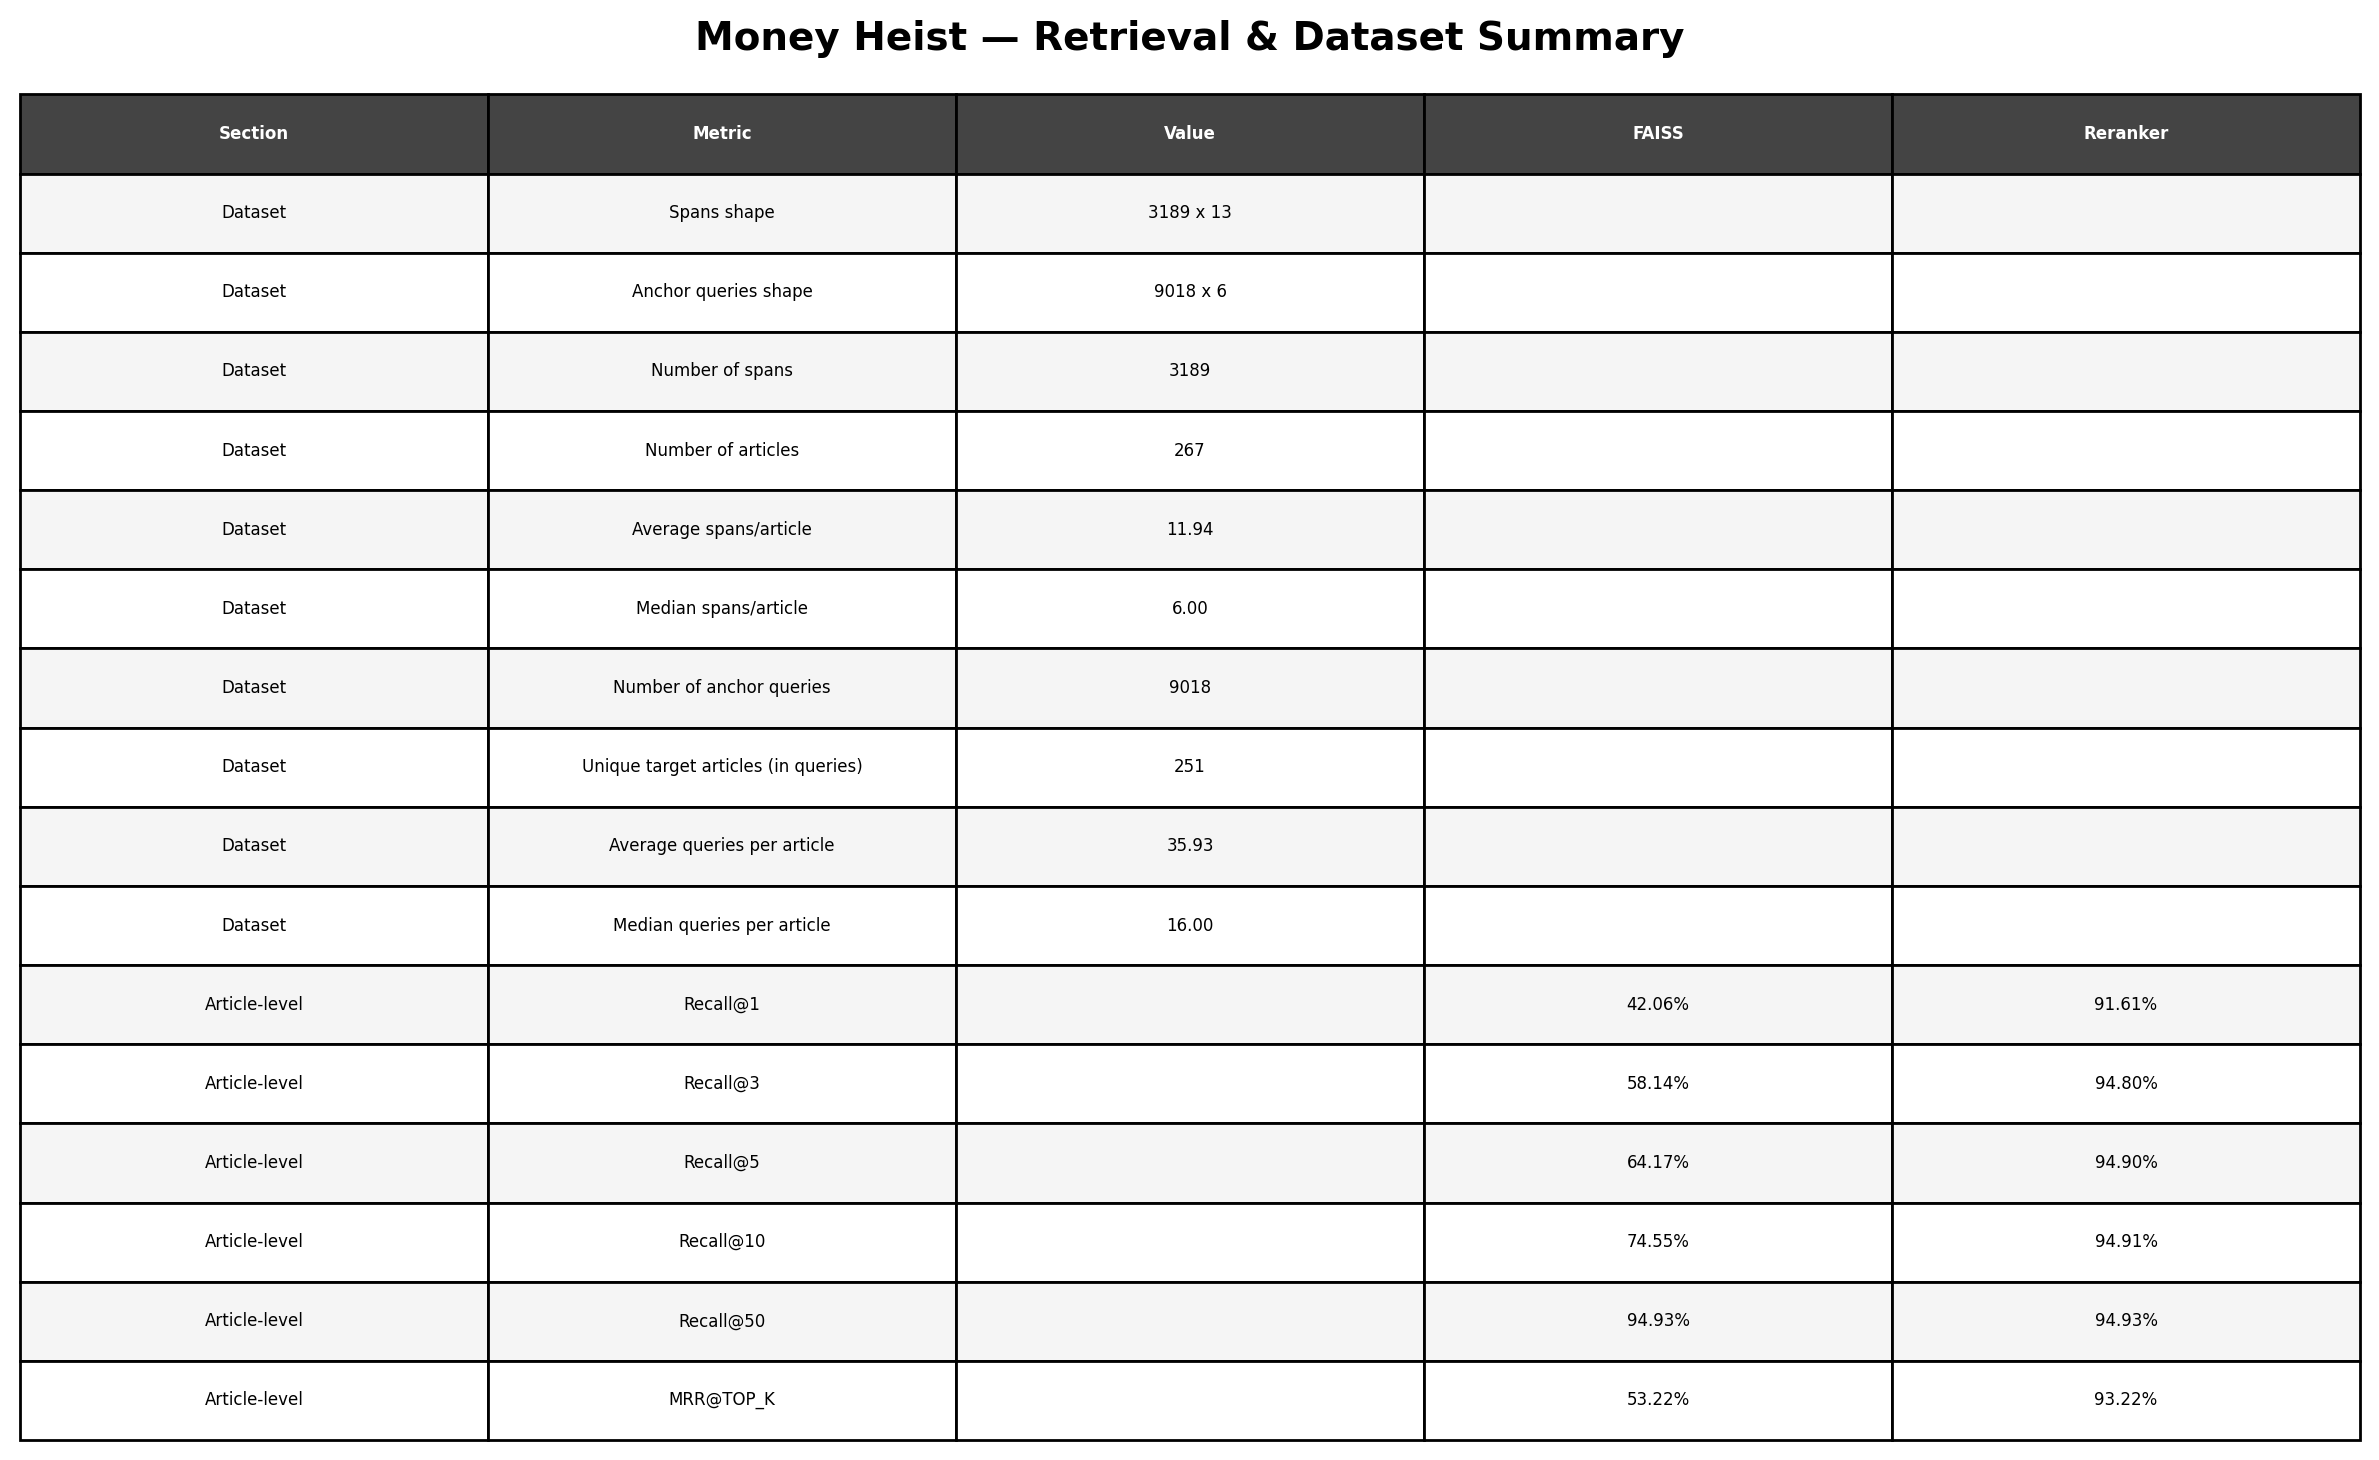

In [13]:
import matplotlib.pyplot as plt
from matplotlib.table import Table
import pandas as pd

# -------------------- 0. Config --------------------
domain_title = DOMAIN.replace("-", " ").title()   # "money-heist" -> "Money Heist"

# Paths
art_rerank_metrics_csv = LOGS_DIR / "article_reranker" / DOMAIN / f"article_reranker_vs_faiss_metrics_{DOMAIN}.csv"

# -------------------- 1. Compute dataset stats --------------------

spans_shape = spans_df.shape
n_spans = len(spans_df)
n_articles = spans_df["article_id"].nunique()
spans_per_article = spans_df.groupby("article_id")["span_id"].count()
avg_spans_per_article = spans_per_article.mean()
median_spans_per_article = spans_per_article.median()

if anchor_df is not None:
    anchor_shape = anchor_df.shape
    n_queries = len(anchor_df)
    n_unique_target_articles = anchor_df["correct_article_id"].nunique()
    queries_per_article = anchor_df.groupby("correct_article_id")["q_id"].count()
    avg_queries_per_article = queries_per_article.mean()
    median_queries_per_article = queries_per_article.median()
else:
    anchor_shape = (0, 0)
    n_queries = 0
    n_unique_target_articles = 0
    avg_queries_per_article = 0
    median_queries_per_article = 0

# -------------------- 2. Load FAISS vs Reranker metrics fresh --------------------

art_rr = pd.read_csv(art_rerank_metrics_csv)
print("Raw article reranker metrics from CSV:")
display(art_rr)
print("Dtypes before conversion:")
print(art_rr.dtypes)

# Ensure faiss/rerank are numeric (in case they were strings)
for col in ["faiss", "rerank"]:
    art_rr[col] = pd.to_numeric(art_rr[col], errors="coerce")

print("\nDtypes after to_numeric:")
print(art_rr.dtypes)

# Convert to percentages (keep numeric for now)
art_rr_percent = art_rr.copy()
art_rr_percent["faiss"] = (art_rr_percent["faiss"] * 100).round(2)
art_rr_percent["rerank"] = (art_rr_percent["rerank"] * 100).round(2)

print("\nMetrics as numeric percentages:")
display(art_rr_percent)

# -------------------- 3. Build master summary rows --------------------

rows = []

# Dataset overview
rows.append(["Dataset", "Spans shape", f"{spans_shape[0]} x {spans_shape[1]}", "", ""])
rows.append(["Dataset", "Anchor queries shape", f"{anchor_shape[0]} x {anchor_shape[1]}", "", ""])
rows.append(["Dataset", "Number of spans", f"{n_spans}", "", ""])
rows.append(["Dataset", "Number of articles", f"{n_articles}", "", ""])
rows.append(["Dataset", "Average spans/article", f"{avg_spans_per_article:.2f}", "", ""])
rows.append(["Dataset", "Median spans/article", f"{median_spans_per_article:.2f}", "", ""])
rows.append(["Dataset", "Number of anchor queries", f"{n_queries}", "", ""])
rows.append(["Dataset", "Unique target articles (in queries)", f"{n_unique_target_articles}", "", ""])
rows.append(["Dataset", "Average queries per article", f"{avg_queries_per_article:.2f}", "", ""])
rows.append(["Dataset", "Median queries per article", f"{median_queries_per_article:.2f}", "", ""])

# Article-level metrics (FAISS vs Reranker, as percentages with % sign)
for _, r in art_rr_percent.iterrows():
    metric_name = r["metric"]
    faiss_val = f"{r['faiss']:.2f}%"
    rerank_val = f"{r['rerank']:.2f}%"
    rows.append(["Article-level", metric_name, "", faiss_val, rerank_val])

summary_cols = ["Section", "Metric", "Value", "FAISS", "Reranker"]
summary_df = pd.DataFrame(rows, columns=summary_cols)

print(f"\nMaster summary table for {domain_title}:")
display(summary_df)

# -------------------- 4. Render as a table image (compatible & sharp) --------------------

fig_height = max(4, len(summary_df) * 0.4 + 1)

# High DPI for sharp text
fig, ax = plt.subplots(figsize=(12, fig_height), dpi=200)
ax.set_axis_off()

tbl = Table(ax, bbox=[0, 0, 1, 1])

n_rows, n_cols = summary_df.shape
col_width = 1.0 / n_cols
row_height = 1.0 / (n_rows + 1)

# ------------ HEADER ------------
for j, col_name in enumerate(summary_df.columns):
    cell = tbl.add_cell(
        row=0,
        col=j,
        width=col_width,
        height=row_height,
        text=col_name,
        loc="center",
        facecolor="#444444",
    )
    cell.get_text().set_color("white")
    cell.get_text().set_fontweight("bold")
    cell.get_text().set_fontsize(11)

# ------------ DATA ROWS ------------
for i in range(n_rows):
    for j, col_name in enumerate(summary_df.columns):
        val = str(summary_df.iloc[i, j])
        bc = "#f5f5f5" if i % 2 == 0 else "white"

        cell = tbl.add_cell(
            row=i + 1,
            col=j,
            width=col_width,
            height=row_height,
            text=val,
            loc="center",
            facecolor=bc,
        )
        cell.get_text().set_fontsize(10)

ax.add_table(tbl)

plt.title(
    f"{domain_title} — Retrieval & Dataset Summary",
    pad=16,
    fontsize=14,
    fontweight="bold"
)

plt.tight_layout()
plt.show()

Raw article reranker metrics from CSV:


,metric,faiss,rerank
0,Recall@1,0.420603,0.916057
1,Recall@3,0.581393,0.947993
2,Recall@5,0.641717,0.948991
3,Recall@10,0.745509,0.949102
4,Recall@50,0.949324,0.949324
5,MRR@TOP_K,0.532198,0.932168


Dtypes before conversion:
metric     object
faiss     float64
rerank    float64
dtype: object

Dtypes after to_numeric:
metric     object
faiss     float64
rerank    float64
dtype: object

Metrics as numeric percentages with improvement:


,metric,faiss,rerank,faiss_pct,rerank_pct,improvement_pp
0,Recall@1,0.420603,0.916057,42.06,91.61,49.55
1,Recall@3,0.581393,0.947993,58.14,94.80,36.66
2,Recall@5,0.641717,0.948991,64.17,94.90,30.73
3,Recall@10,0.745509,0.949102,74.55,94.91,20.36
4,Recall@50,0.949324,0.949324,94.93,94.93,0.00
5,MRR@TOP_K,0.532198,0.932168,53.22,93.22,40.00



Master summary table for Money Heist:


,Section,Metric,Value,FAISS,Reranker,Improvement (pp)
0,Dataset,Spans shape,3189 x 13,,,
1,Dataset,Anchor queries shape,9018 x 6,,,
2,Dataset,Number of spans,3189,,,
3,Dataset,Number of articles,267,,,
4,Dataset,Average spans/article,11.94,,,
5,Dataset,Median spans/article,6.00,,,
6,Dataset,Number of anchor queries,9018,,,
7,Dataset,Unique target articles (in queries),251,,,
8,Dataset,Average queries per article,35.93,,,
9,Dataset,Median queries per article,16.00,,,


Saved TABLE figure to:
 PNG: /data/sundeep/Fandom_SI/data/logs/money-heist_summary_table.png
 PDF: /data/sundeep/Fandom_SI/data/logs/money-heist_summary_table.pdf


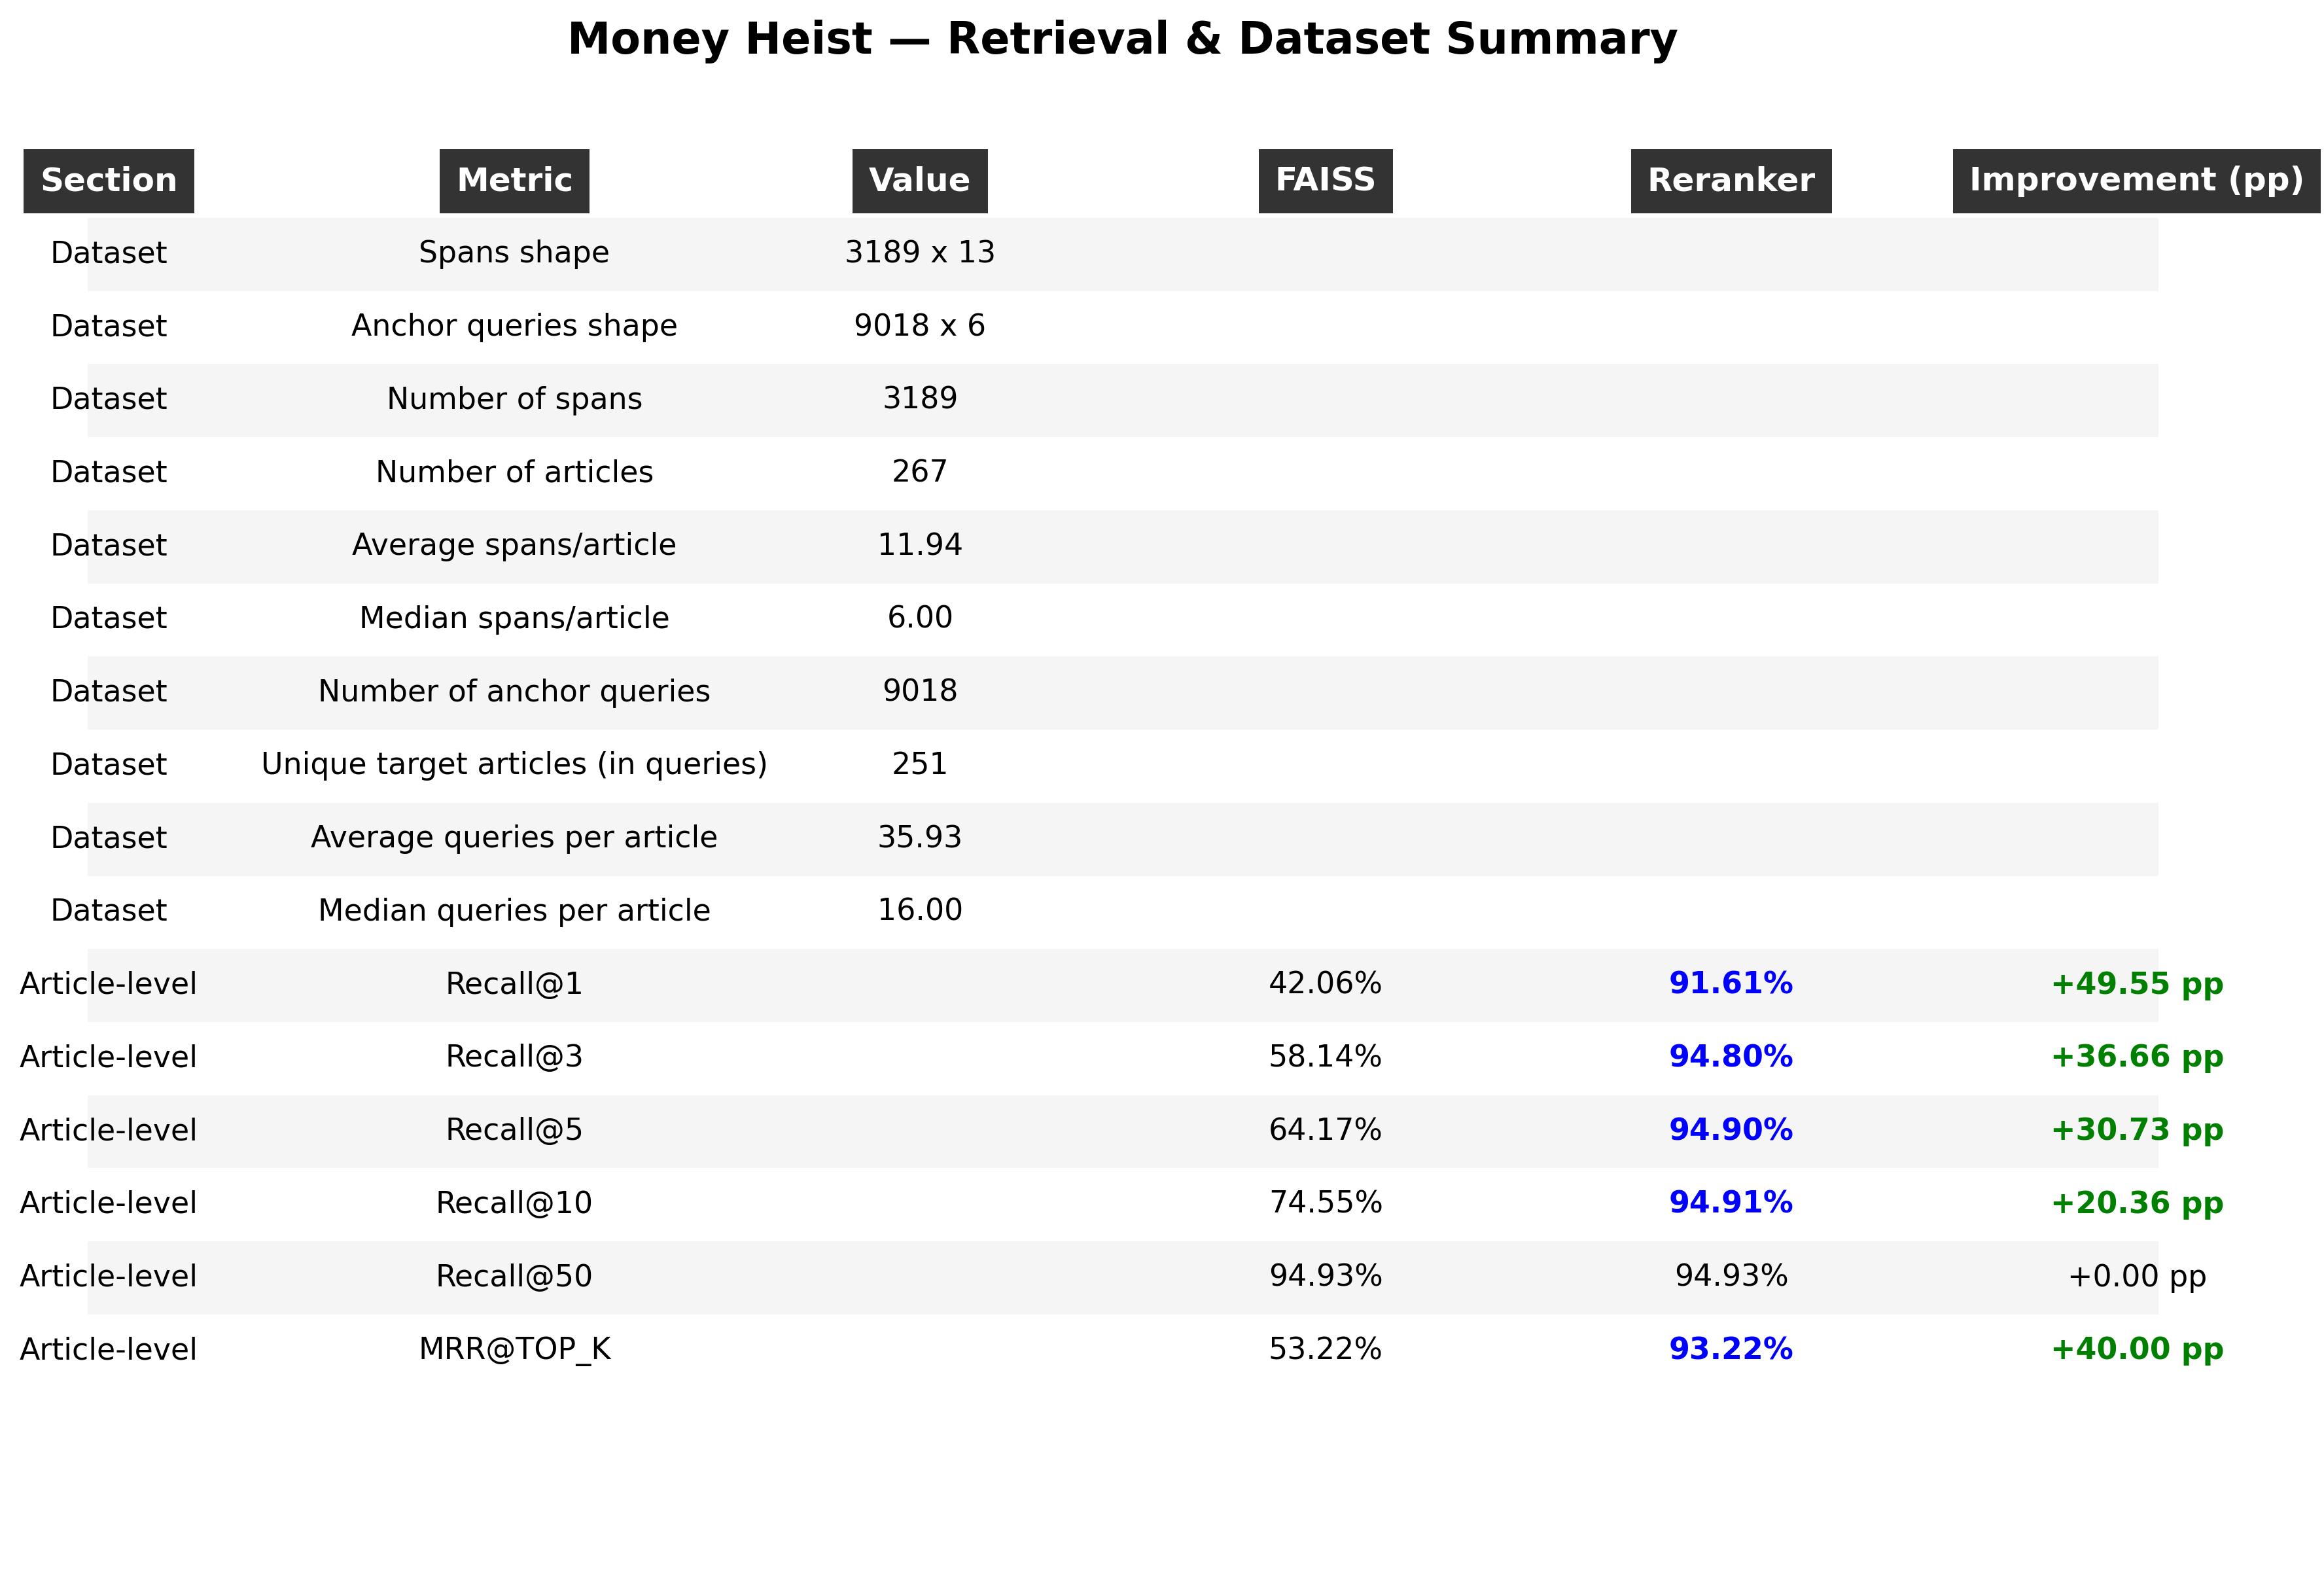

Saved BAR CHART figure to:
 PNG: /data/sundeep/Fandom_SI/data/logs/money-heist_summary_bar.png
 PDF: /data/sundeep/Fandom_SI/data/logs/money-heist_summary_bar.pdf


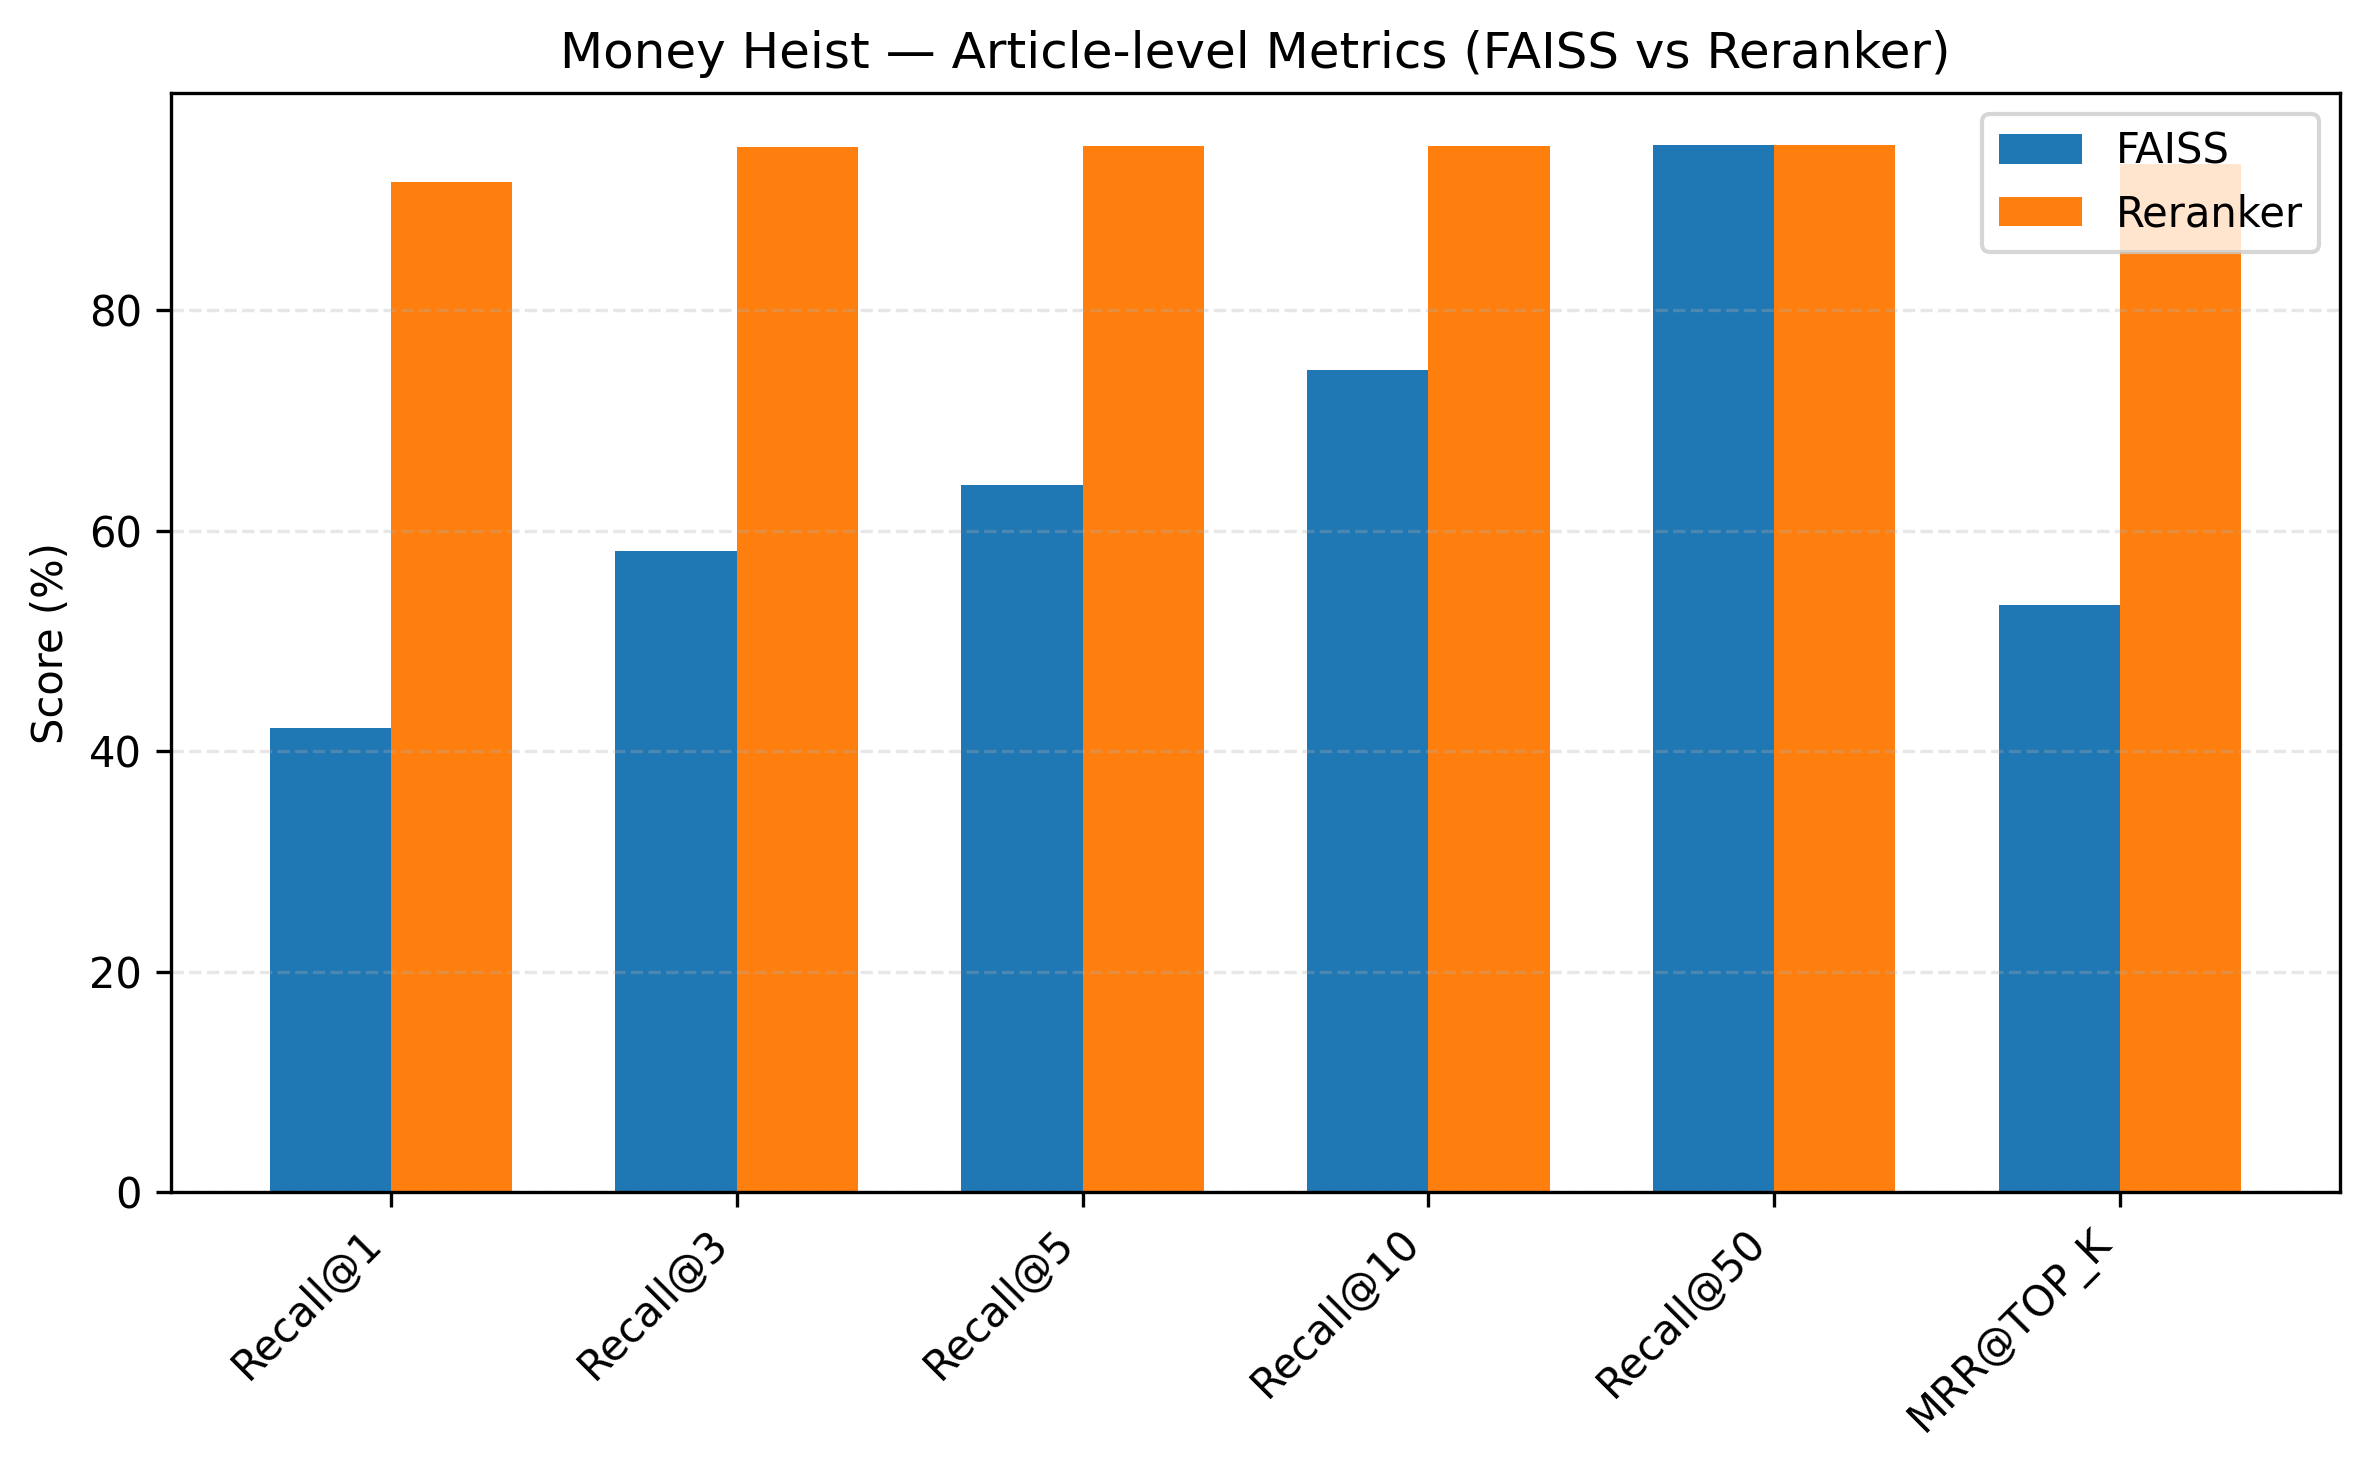

Saved SPARKLINE figure to:
 PNG: /data/sundeep/Fandom_SI/data/logs/money-heist_summary_sparkline.png
 PDF: /data/sundeep/Fandom_SI/data/logs/money-heist_summary_sparkline.pdf


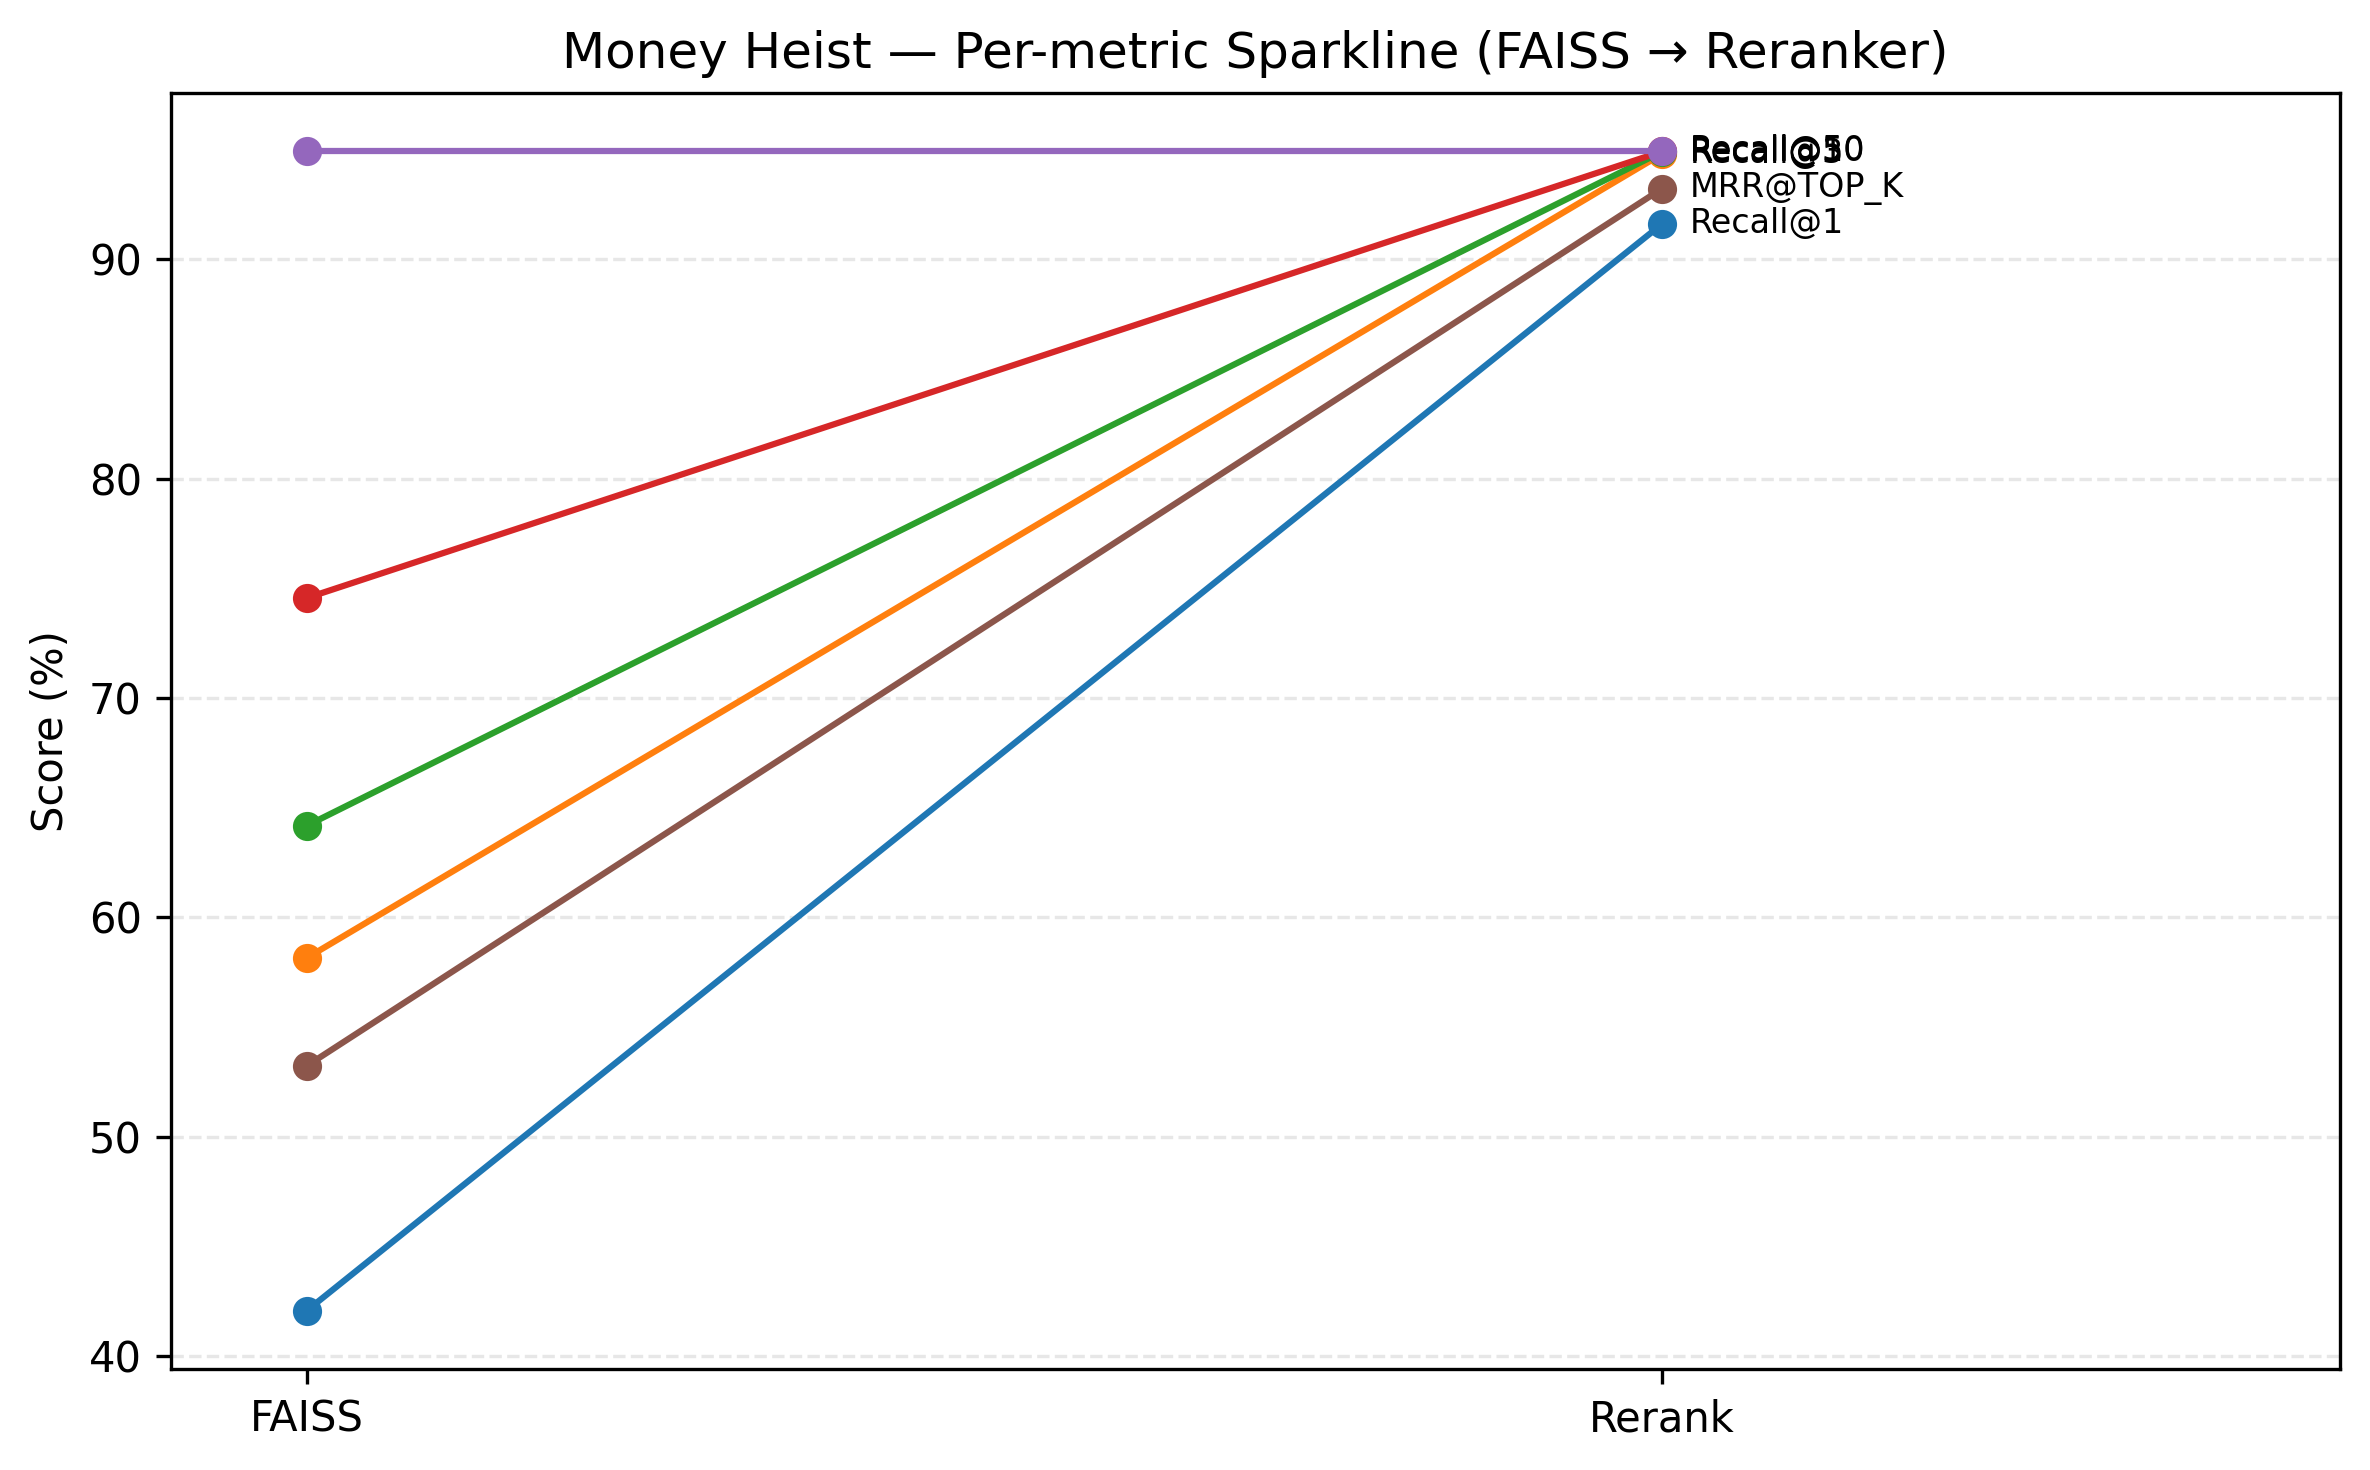

In [14]:
import matplotlib.pyplot as plt
from matplotlib.table import Table
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np

# -------------------- 0. Config --------------------
domain_title = DOMAIN.replace("-", " ").title()   # "money-heist" -> "Money Heist"

art_rerank_metrics_csv = LOGS_DIR / "article_reranker" / DOMAIN / f"article_reranker_vs_faiss_metrics_{DOMAIN}.csv"

# -------------------- 1. Compute dataset stats --------------------

spans_shape = spans_df.shape
n_spans = len(spans_df)
n_articles = spans_df["article_id"].nunique()
spans_per_article = spans_df.groupby("article_id")["span_id"].count()
avg_spans_per_article = spans_per_article.mean()
median_spans_per_article = spans_per_article.median()

if anchor_df is not None:
    anchor_shape = anchor_df.shape
    n_queries = len(anchor_df)
    n_unique_target_articles = anchor_df["correct_article_id"].nunique()
    queries_per_article = anchor_df.groupby("correct_article_id")["q_id"].count()
    avg_queries_per_article = queries_per_article.mean()
    median_queries_per_article = queries_per_article.median()
else:
    anchor_shape = (0, 0)
    n_queries = 0
    n_unique_target_articles = 0
    avg_queries_per_article = 0
    median_queries_per_article = 0

# -------------------- 2. Load FAISS vs Reranker metrics fresh --------------------

art_rr = pd.read_csv(art_rerank_metrics_csv)
print("Raw article reranker metrics from CSV:")
display(art_rr)
print("Dtypes before conversion:")
print(art_rr.dtypes)

for col in ["faiss", "rerank"]:
    art_rr[col] = pd.to_numeric(art_rr[col], errors="coerce")

print("\nDtypes after to_numeric:")
print(art_rr.dtypes)

# Convert to percentages (numeric)
art_rr_percent = art_rr.copy()
art_rr_percent["faiss_pct"] = (art_rr_percent["faiss"] * 100).round(2)
art_rr_percent["rerank_pct"] = (art_rr_percent["rerank"] * 100).round(2)
art_rr_percent["improvement_pp"] = (art_rr_percent["rerank_pct"] - art_rr_percent["faiss_pct"]).round(2)

print("\nMetrics as numeric percentages with improvement:")
display(art_rr_percent)

# -------------------- 3. Build master summary rows --------------------

rows = []

# Dataset overview
rows.append(["Dataset", "Spans shape", f"{spans_shape[0]} x {spans_shape[1]}", "", "", ""])
rows.append(["Dataset", "Anchor queries shape", f"{anchor_shape[0]} x {anchor_shape[1]}", "", "", ""])
rows.append(["Dataset", "Number of spans", f"{n_spans}", "", "", ""])
rows.append(["Dataset", "Number of articles", f"{n_articles}", "", "", ""])
rows.append(["Dataset", "Average spans/article", f"{avg_spans_per_article:.2f}", "", "", ""])
rows.append(["Dataset", "Median spans/article", f"{median_spans_per_article:.2f}", "", "", ""])
rows.append(["Dataset", "Number of anchor queries", f"{n_queries}", "", "", ""])
rows.append(["Dataset", "Unique target articles (in queries)", f"{n_unique_target_articles}", "", "", ""])
rows.append(["Dataset", "Average queries per article", f"{avg_queries_per_article:.2f}", "", "", ""])
rows.append(["Dataset", "Median queries per article", f"{median_queries_per_article:.2f}", "", "", ""])

# Article-level metrics (FAISS vs Reranker, as percentages with improvement)
for _, r in art_rr_percent.iterrows():
    metric_name = r["metric"]
    faiss_str = f"{r['faiss_pct']:.2f}%"
    rerank_str = f"{r['rerank_pct']:.2f}%"
    imp_str = f"{r['improvement_pp']:+.2f} pp"
    rows.append(["Article-level", metric_name, "", faiss_str, rerank_str, imp_str])

summary_cols = ["Section", "Metric", "Value", "FAISS", "Reranker", "Improvement (pp)"]
summary_df = pd.DataFrame(rows, columns=summary_cols)

print(f"\nMaster summary table for {domain_title}:")
display(summary_df)

# -------------------- 4. Visualization: separate sharp figures --------------------

# Only metrics rows for charts
metrics_df = art_rr_percent[["metric", "faiss_pct", "rerank_pct", "improvement_pp"]].copy()

# ---------- 4A. SHARP TABLE FIGURE (no Table(), just text) ----------

fig_h = len(summary_df) * 0.45 + 1
fig_w = 12

fig_table, ax_table = plt.subplots(figsize=(fig_w, fig_h), dpi=300)
ax_table.axis("off")

# x positions for columns
col_x = np.linspace(0.02, 0.98, summary_df.shape[1])

# Header row (dark background, white text)
header_y = 0.95
for j, col in enumerate(summary_df.columns):
    ax_table.text(
        col_x[j], header_y, col,
        ha="center", va="center",
        fontsize=12, fontweight="bold", color="white",
        bbox=dict(facecolor="#333333", edgecolor="none", pad=6)
    )

# Data rows
start_y = 0.90
row_h = 1 / (len(summary_df) + 4)

for i, row in summary_df.iterrows():
    y = start_y - i * row_h
    bg = "#f5f5f5" if i % 2 == 0 else "#ffffff"

    # full-width background stripe
    ax_table.add_patch(
        plt.Rectangle((0.01, y - row_h / 2), 0.98, row_h,
                      facecolor=bg, edgecolor="none")
    )

    for j, col in enumerate(summary_df.columns):
        text_val = str(row[col])
        # basic text
        txt = ax_table.text(
            col_x[j], y, text_val,
            ha="center", va="center",
            fontsize=11, color="black"
        )

        # Style only Article-level metric rows
        if row["Section"] == "Article-level":
            if summary_df.columns[j] == "Improvement (pp)":
                try:
                    imp_val = float(text_val.replace(" pp", ""))
                    if imp_val > 0:
                        txt.set_color("green")
                        txt.set_fontweight("bold")
                    elif imp_val < 0:
                        txt.set_color("red")
                        txt.set_fontweight("bold")
                except Exception:
                    pass
            if summary_df.columns[j] == "Reranker":
                try:
                    mrow = metrics_df[metrics_df["metric"] == row["Metric"]]
                    if not mrow.empty:
                        imp_val = float(mrow["improvement_pp"].iloc[0])
                        if imp_val > 0:
                            txt.set_color("blue")
                            txt.set_fontweight("bold")
                except Exception:
                    pass

ax_table.set_title(
    f"{domain_title} — Retrieval & Dataset Summary",
    fontsize=16, fontweight="bold", pad=20
)
plt.tight_layout()

table_png = PROJECT_ROOT / "data" / "logs" / f"{DOMAIN}_summary_table.png"
table_pdf = PROJECT_ROOT / "data" / "logs" / f"{DOMAIN}_summary_table.pdf"
fig_table.savefig(table_png, bbox_inches="tight")
fig_table.savefig(table_pdf, bbox_inches="tight")

print("Saved TABLE figure to:")
print(" PNG:", table_png)
print(" PDF:", table_pdf)

plt.show()


# ---------- 4B. BAR CHART: FAISS vs RERANKER ----------

fig_bar, ax_bar = plt.subplots(figsize=(8, 5), dpi=300)

x = np.arange(len(metrics_df))
width = 0.35

ax_bar.bar(x - width/2, metrics_df["faiss_pct"], width, label="FAISS")
ax_bar.bar(x + width/2, metrics_df["rerank_pct"], width, label="Reranker")

ax_bar.set_xticks(x)
ax_bar.set_xticklabels(metrics_df["metric"], rotation=45, ha="right")
ax_bar.set_ylabel("Score (%)")
ax_bar.set_title(f"{domain_title} — Article-level Metrics (FAISS vs Reranker)")
ax_bar.legend()
ax_bar.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()

bar_png = PROJECT_ROOT / "data" / "logs" / f"{DOMAIN}_summary_bar.png"
bar_pdf = PROJECT_ROOT / "data" / "logs" / f"{DOMAIN}_summary_bar.pdf"
fig_bar.savefig(bar_png, bbox_inches="tight")
fig_bar.savefig(bar_pdf, bbox_inches="tight")

print("Saved BAR CHART figure to:")
print(" PNG:", bar_png)
print(" PDF:", bar_pdf)

plt.show()


# ---------- 4C. SPARKLINE-STYLE METRIC FIGURE ----------

fig_spark, ax_spark = plt.subplots(figsize=(8, 5), dpi=300)

for idx, row in metrics_df.iterrows():
    xs = [0, 1]
    ys = [row["faiss_pct"], row["rerank_pct"]]
    ax_spark.plot(xs, ys, marker="o", linewidth=1.5)
    ax_spark.text(1.02, ys[1], row["metric"], va="center", fontsize=8)

ax_spark.set_xlim(-0.1, 1.5)
ax_spark.set_xticks([0, 1])
ax_spark.set_xticklabels(["FAISS", "Rerank"])
ax_spark.set_ylabel("Score (%)")
ax_spark.set_title(f"{domain_title} — Per-metric Sparkline (FAISS → Reranker)")
ax_spark.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()

spark_png = PROJECT_ROOT / "data" / "logs" / f"{DOMAIN}_summary_sparkline.png"
spark_pdf = PROJECT_ROOT / "data" / "logs" / f"{DOMAIN}_summary_sparkline.pdf"
fig_spark.savefig(spark_png, bbox_inches="tight")
fig_spark.savefig(spark_pdf, bbox_inches="tight")

print("Saved SPARKLINE figure to:")
print(" PNG:", spark_png)
print(" PDF:", spark_pdf)

plt.show()

In [15]:
#!/usr/bin/env python3
"""
checkpoints.py

Quick sanity dashboard for the Fandom_SI retrieval pipeline.

Compares:

1) Article-level FAISS-only retrieval (07_eval_article_retrieval.py)
   - metrics: data/logs/article_retrieval/article_retrieval_metrics_<domain>.csv

2) Article-level FAISS vs Article-Reranker (09_eval_article_reranker.py)
   - metrics: data/logs/article_reranker/<domain>/article_reranker_vs_faiss_metrics_<domain>.csv

3) Span-level reranker ranking (12_eval_span_reranker.py)
   - metrics parsed from latest:
     data/logs/reranker_eval/<domain>/*_12_eval_span_reranker.log

Outputs:
- Prints per-source metrics
- Prints a combined pandas DataFrame comparing all systems.
"""

import csv
import glob
import json
import re
from pathlib import Path
from urllib.parse import urlparse

import pandas as pd
import yaml


# ---------------------------------------------------
# Project root & domain
# ---------------------------------------------------

PROJECT_ROOT = Path("/data/sundeep/Fandom_SI")
CONFIG_PATH = PROJECT_ROOT / "configs" / "scraping.yaml"

if not CONFIG_PATH.exists():
    raise FileNotFoundError(f"Missing config: {CONFIG_PATH}")

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f) or {}

DOMAIN = cfg.get("domain") or cfg.get("domain_slug")
if not DOMAIN:
    base_url = cfg.get("base_url", "").rstrip("/")
    if not base_url:
        raise ValueError(
            "Could not determine DOMAIN. Please set 'domain' (or 'domain_slug') "
            "or 'base_url' in configs/scraping.yaml"
        )
    DOMAIN = urlparse(base_url).netloc.split(".")[0]

print(f"PROJECT_ROOT = {PROJECT_ROOT}")
print(f"DOMAIN       = {DOMAIN}")

# ---------------------------------------------------
# Paths
# ---------------------------------------------------

# 1) Article-level FAISS-only (07_eval_article_retrieval.py)
ARTICLE_RETRIEVAL_DIR = PROJECT_ROOT / "data" / "logs" / "article_retrieval"
ARTICLE_RETRIEVAL_METRICS = ARTICLE_RETRIEVAL_DIR / f"article_retrieval_metrics_{DOMAIN}.csv"

# 2) Article vs reranker (09_eval_article_reranker.py)
ARTICLE_RERANK_DIR = PROJECT_ROOT / "data" / "logs" / "article_reranker" / DOMAIN
ARTICLE_RERANK_METRICS = ARTICLE_RERANK_DIR / f"article_reranker_vs_faiss_metrics_{DOMAIN}.csv"

# 3) Span reranker (12_eval_span_reranker.py) logs
SPAN_RERANK_LOG_DIR = PROJECT_ROOT / "data" / "logs" / "reranker_eval" / DOMAIN


# ---------------------------------------------------
# Helper: load article FAISS-only metrics (07)
# ---------------------------------------------------

def load_article_faiss_only_metrics(csv_path: Path) -> dict:
    """
    CSV structure (07_eval_article_retrieval.py):
        metric, faiss

    Returns dict: {metric_name: value}
    """
    metrics = {}
    if not csv_path.exists():
        print(f"[WARN] Article FAISS-only metrics file not found: {csv_path}")
        return metrics

    print(f"\n[INFO] Loading article FAISS-only metrics from:\n  {csv_path}")
    with open(csv_path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            name = row["metric"]
            val = float(row["faiss"])
            metrics[name] = val

    return metrics


# ---------------------------------------------------
# Helper: load article FAISS vs reranker metrics (09)
# ---------------------------------------------------

def load_article_rerank_metrics(csv_path: Path):
    """
    CSV structure (09_eval_article_reranker.py):
        metric, faiss, rerank

    Returns two dicts:
        faiss_metrics   = {metric_name: value}
        rerank_metrics  = {metric_name: value}
    """
    faiss_metrics = {}
    rerank_metrics = {}

    if not csv_path.exists():
        print(f"[WARN] Article reranker metrics file not found: {csv_path}")
        return faiss_metrics, rerank_metrics

    print(f"\n[INFO] Loading article FAISS vs reranker metrics from:\n  {csv_path}")
    with open(csv_path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            name = row["metric"]
            faiss_val = row.get("faiss")
            rerank_val = row.get("rerank")
            if faiss_val is not None and faiss_val != "":
                faiss_metrics[name] = float(faiss_val)
            if rerank_val is not None and rerank_val != "":
                rerank_metrics[name] = float(rerank_val)

    return faiss_metrics, rerank_metrics


# ---------------------------------------------------
# Helpers: span reranker metrics from log (12)
# ---------------------------------------------------

def get_latest_span_log(log_dir: Path) -> Path | None:
    """
    Finds the latest log that ends with '_12_eval_span_reranker.log'
    in the given directory.
    """
    pattern = str(log_dir / "*_12_eval_span_reranker.log")
    matches = glob.glob(pattern)

    if not matches:
        print(f"[WARN] No span reranker logs match pattern: {pattern}")
        return None

    paths = [Path(p) for p in matches]
    latest = max(paths, key=lambda p: p.stat().st_mtime)
    return latest


def parse_span_reranker_metrics_from_log(log_path: Path) -> dict:
    """
    Extracts metrics like:
      Recall@1: 0.xxxx
      Recall@3: 0.xxxx
      ...
      MRR@10: 0.xxxx
      NDCG@10: 0.xxxx

    from the log produced by 12_eval_span_reranker.py.
    """
    metrics = {}
    if log_path is None or not log_path.exists():
        print(f"[WARN] span reranker log not found: {log_path}")
        return metrics

    print(f"\n[INFO] Parsing span reranker metrics from:\n  {log_path}")

    # Match lines like "Recall@1: 0.1234", "MRR@10: 0.5678", "NDCG@10: 0.9012"
    pattern = re.compile(r"(Recall@\d+|MRR@10|NDCG@10):\s+([0-9.]+)")
    with open(log_path, "r", encoding="utf-8") as f:
        for line in f:
            m = pattern.search(line)
            if m:
                name = m.group(1)
                val = float(m.group(2))
                metrics[name] = val
    return metrics


# ---------------------------------------------------
# Main: load all metrics & compare
# ---------------------------------------------------

def main():
    # 1) Article FAISS-only (07)
    article_faiss_07 = load_article_faiss_only_metrics(ARTICLE_RETRIEVAL_METRICS)

    # 2) Article FAISS vs rerank (09)
    article_faiss_09, article_rerank = load_article_rerank_metrics(ARTICLE_RERANK_METRICS)

    # 3) Span reranker ranking (12)
    latest_span_log = get_latest_span_log(SPAN_RERANK_LOG_DIR)
    span_rerank = parse_span_reranker_metrics_from_log(latest_span_log)

    # ---------------------------------------------------
    # Sanity: compare FAISS metrics from 07 vs 09 (if both exist)
    # ---------------------------------------------------
    if article_faiss_07 and article_faiss_09:
        print("\n[CHECK] Comparing FAISS metrics from 07 vs 09 (should be very close):")
        common_metrics = sorted(set(article_faiss_07.keys()) & set(article_faiss_09.keys()))
        for m in common_metrics:
            v07 = article_faiss_07[m]
            v09 = article_faiss_09[m]
            diff = abs(v07 - v09)
            print(f"  {m:<15}  07={v07:.6f} | 09={v09:.6f} | diff={diff:.6e}")
    else:
        print("\n[WARN] Cannot cross-check FAISS metrics between 07 and 09 (missing file).")

    # ---------------------------------------------------
    # Build combined comparison DataFrame
    # ---------------------------------------------------
    # Unified metric name to row index
    metric_names = set()
    metric_names |= set(article_faiss_07.keys())
    metric_names |= set(article_faiss_09.keys())
    metric_names |= set(article_rerank.keys())
    metric_names |= set(span_rerank.keys())

    if not metric_names:
        print("\n[ERROR] No metrics found from any source.")
        return

    metric_names = sorted(metric_names)

    rows = []
    for m in metric_names:
        rows.append(
            {
                "metric": m,
                "Article_FAISS_07": article_faiss_07.get(m),
                "Article_FAISS_09": article_faiss_09.get(m),
                "Article_Reranker": article_rerank.get(m),
                "Span_Reranker": span_rerank.get(m),
            }
        )

    df = pd.DataFrame(rows).set_index("metric")

    print("\n================= COMBINED METRICS TABLE =================")
    print(df)
    print("==========================================================\n")

    # Optionally: pretty subset for the 'main trio' recalls
    focus_metrics = [m for m in df.index if m.startswith("Recall@")]
    if focus_metrics:
        print("Focus: Recall@k comparison (rows with Recall@...):\n")
        print(df.loc[focus_metrics])
        print()

    print("Done.")


if __name__ == "__main__":
    main()

PROJECT_ROOT = /data/sundeep/Fandom_SI
DOMAIN       = money-heist

[INFO] Loading article FAISS-only metrics from:
  /data/sundeep/Fandom_SI/data/logs/article_retrieval/article_retrieval_metrics_money-heist.csv

[INFO] Loading article FAISS vs reranker metrics from:
  /data/sundeep/Fandom_SI/data/logs/article_reranker/money-heist/article_reranker_vs_faiss_metrics_money-heist.csv

[INFO] Parsing span reranker metrics from:
  /data/sundeep/Fandom_SI/data/logs/reranker_eval/money-heist/2025-11-23_01-36-23_12_eval_span_reranker.log

[CHECK] Comparing FAISS metrics from 07 vs 09 (should be very close):
  MRR@TOP_K        07=0.532198 | 09=0.532198 | diff=0.000000e+00
  Recall@1         07=0.420603 | 09=0.420603 | diff=0.000000e+00
  Recall@10        07=0.745509 | 09=0.745509 | diff=0.000000e+00
  Recall@3         07=0.581393 | 09=0.581393 | diff=0.000000e+00
  Recall@5         07=0.641717 | 09=0.641717 | diff=0.000000e+00
  Recall@50        07=0.949324 | 09=0.949324 | diff=0.000000e+00

====